In [ ]:
# -----------------------------------------------
# Register Frame 15 to All 30 Templates=====Base Function
# -----------------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimpleITK as sitk
from scipy.ndimage import center_of_mass
from IPython.display import display
from PIL import Image as PILImage

# ------------------ Paths ------------------
input_path = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/data/20213_2_0_masked.npy"
template_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/templates/Template10allsimNonrigid"
template_prefix = "template_phase"
template_suffix = "_similarity_10.npy"
save_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/notebooks/analysis_output/test15base"
os.makedirs(save_dir, exist_ok=True)

# ------------------ Load Test Frame ------------------
full_data = np.load(input_path)
frame_index = 15
test_frame = (np.abs(full_data[frame_index]) > 1e-6).astype(np.uint8)

# ------------------ Utility Functions ------------------
def compute_stats(mask):
    area = int(np.sum(mask))
    com_y, com_x = center_of_mass(mask) if area > 0 else (np.nan, np.nan)
    return area, com_y, com_x

def register_to_template(mask, template):
    # Convert numpy arrays to SimpleITK images (float32 is needed for registration)
    ref_img = sitk.GetImageFromArray(template.astype(np.float32))   # Fixed image (target)
    moving_img = sitk.GetImageFromArray(mask.astype(np.float32))    # Moving image (input mask)

    # Initialize a BSpline transform on the reference image with grid spacing [10,10]
    transform = sitk.BSplineTransformInitializer(ref_img, [10, 10])

    # Set up the registration method
    registration = sitk.ImageRegistrationMethod()

    # Define the similarity metric: Mean Squares works well for similar images
    registration.SetMetricAsMeanSquares()

    # Set optimizer: Limited-memory BFGS-B, a gradient-based optimizer
    registration.SetOptimizerAsLBFGSB()

    # Set initial transform: inPlace=False ensures a copy is used
    registration.SetInitialTransform(transform, inPlace=False)

    # Set interpolation method used during optimization
    registration.SetInterpolator(sitk.sitkLinear)

    # Run the registration: returns the final optimized transform
    final_transform = registration.Execute(ref_img, moving_img)

    # Resample the moving image using the computed transform
    aligned = sitk.Resample(moving_img, ref_img, final_transform, sitk.sitkBSpline, 0.0)

    # Convert resampled result back to binary mask (using threshold)
    aligned = sitk.GetArrayFromImage(aligned) > 0.5

    # Return as uint8 binary mask
    return aligned.astype(np.uint8)


# ------------------ Loop Over All Templates ------------------
rows = []
aligned_masks = []

for i in range(30):
    path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
    if not os.path.exists(path):
        print("Missing template:", path)
        continue

    template = np.load(path)
    template = (template > 0.5).astype(np.uint8)

    aligned = register_to_template(test_frame, template)

    a_tpl, y_tpl, x_tpl = compute_stats(template)
    a_in, y_in, x_in = compute_stats(test_frame)
    a_out, y_out, x_out = compute_stats(aligned)

    rows.append({
        'Frame': i,
        'Area_template': a_tpl,
        'COM_template_y': y_tpl,
        'COM_template_x': x_tpl,
        'Area_input': a_in,
        'COM_input_y': y_in,
        'COM_input_x': x_in,
        'Area_aligned': a_out,
        'COM_aligned_y': y_out,
        'COM_aligned_x': x_out,
        'Delta_A_after': a_out - a_tpl,
        'Delta_COM_y_after': y_out - y_tpl,
        'Delta_COM_x_after': x_out - x_tpl,
        'Delta_A_input_aligned': a_out - a_in,
        'Delta_COM_y_input_aligned': y_out - y_in,
        'Delta_COM_x_input_aligned': x_out - x_in,
    })

    aligned_masks.append(aligned)

# ------------------ Save Table ------------------
df = pd.DataFrame(rows)
csv_path = os.path.join(save_dir, "frame15_to_all_templates.csv")
df.to_csv(csv_path, index=False)
print("Saved table to:", csv_path)

# ------------------ Save/Show Image Grid ------------------
aligned_masks = np.array(aligned_masks)
fig, axes = plt.subplots(30, 3, figsize=(12, 60))

for i in range(30):
    axes[i, 0].imshow(test_frame, cmap='gray')
    axes[i, 0].set_title(f"Input Frame {frame_index}", fontsize=8)
    axes[i, 0].axis('off')

    path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
    tpl = np.load(path)
    tpl = (tpl > 0.5).astype(np.uint8)
    axes[i, 1].imshow(tpl, cmap='gray')
    axes[i, 1].set_title(f"Template {i}", fontsize=8)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(aligned_masks[i], cmap='gray')
    axes[i, 2].set_title(f"Aligned {i}", fontsize=8)
    axes[i, 2].axis('off')

plt.tight_layout()
img_path = os.path.join(save_dir, "frame15_aligned_to_all_templates.png")
plt.savefig(img_path, dpi=300)
plt.close()
print("Saved visualization:", img_path)

# ------------------ Show Results ------------------
display(df.round(2))

img = PILImage.open(img_path)
plt.figure(figsize=(12, 80))
plt.imshow(img)
plt.axis('off')
plt.title("Frame 15: Input vs. Template vs. Aligned (to 30 Templates)", fontsize=14)
plt.show()


In [ ]:
"""
This script improves the deformable registration process by explicitly adding a rigid pre-alignment step
based on the center of mass (CoM) of the input and template masks. In earlier attempts, registration
using only BSpline or composite transforms resulted in no meaningful deformation, and the final transform
was always the identity.

🔍 Problem:
    - The input and template masks may be spatially far apart or non-overlapping.
    - When starting registration from a bad initial guess, the optimizer cannot align them and gets stuck.

✅ Solution:
    - First, rigidly align the input mask to the template using their center of mass.
    - Then apply BSpline registration on the pre-aligned input to allow local deformation.

This ensures the optimizer starts from a reasonable initial position, increasing the chance of successful alignment.
"""
# -----------------------------------------------
# Register Frame 15 to All 30 Templates (with CoM pre-align + BSpline)
# -----------------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimpleITK as sitk
from scipy.ndimage import center_of_mass
from IPython.display import display
from PIL import Image as PILImage

# ------------------ Paths ------------------
input_path = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/data/20213_2_0_masked.npy"
template_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/templates/Template10allsimNonrigid"
template_prefix = "template_phase"
template_suffix = "_similarity_10.npy"
save_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/notebooks/analysis_output/test15CoM"
os.makedirs(save_dir, exist_ok=True)

# ------------------ Load Test Frame ------------------
full_data = np.load(input_path)
frame_index = 15
test_frame = (np.abs(full_data[frame_index]) > 1e-6).astype(np.uint8)

# ------------------ Utility Functions ------------------
def compute_stats(mask):
    area = int(np.sum(mask))
    com_y, com_x = center_of_mass(mask) if area > 0 else (np.nan, np.nan)
    return area, com_y, com_x

def center_of_mass_align(mask, template):
    """Shift the mask to match the template based on their center of mass."""
    com_mask = np.array(center_of_mass(mask))
    com_tpl = np.array(center_of_mass(template))
    shift = com_tpl - com_mask  # (y, x)

    image = sitk.GetImageFromArray(mask.astype(np.float32))
    tx = sitk.Euler2DTransform()
    tx.SetTranslation((float(shift[1]), float(shift[0])))

    resampled = sitk.Resample(image, image, tx, sitk.sitkNearestNeighbor, 0.0)
    return sitk.GetArrayFromImage(resampled).astype(np.uint8)

def register_to_template(mask, template):
    # Pre-align using center of mass shift
    mask_prealigned = center_of_mass_align(mask, template)

    # Convert numpy arrays to SimpleITK images
    ref_img = sitk.GetImageFromArray(template.astype(np.float32))
    moving_img = sitk.GetImageFromArray(mask_prealigned.astype(np.float32))

    # Initialize a BSpline transform
    transform = sitk.BSplineTransformInitializer(ref_img, [40, 40])

    registration = sitk.ImageRegistrationMethod()
    registration.SetMetricAsMattesMutualInformation(32)
    registration.SetOptimizerAsLBFGSB(
        gradientConvergenceTolerance=1e-5,
        numberOfIterations=200,
        maximumNumberOfCorrections=5,
        maximumNumberOfFunctionEvaluations=1000
    )
    registration.SetInitialTransform(transform, inPlace=False)
    registration.SetInterpolator(sitk.sitkLinear)

    final_transform = registration.Execute(ref_img, moving_img)
    aligned = sitk.Resample(moving_img, ref_img, final_transform, sitk.sitkNearestNeighbor, 0.0)

    aligned = sitk.GetArrayFromImage(aligned) > 0.5
    return aligned.astype(np.uint8)

# ------------------ Loop Over All Templates ------------------
rows = []
aligned_masks = []

for i in range(30):
    path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
    if not os.path.exists(path):
        print("Missing template:", path)
        continue

    template = np.load(path)
    template = (template > 0.5).astype(np.uint8)

    aligned = register_to_template(test_frame, template)

    a_tpl, y_tpl, x_tpl = compute_stats(template)
    a_in, y_in, x_in = compute_stats(test_frame)
    a_out, y_out, x_out = compute_stats(aligned)

    rows.append({
        'Frame': i,
        'Area_template': a_tpl,
        'COM_template_y': y_tpl,
        'COM_template_x': x_tpl,
        'Area_input': a_in,
        'COM_input_y': y_in,
        'COM_input_x': x_in,
        'Area_aligned': a_out,
        'COM_aligned_y': y_out,
        'COM_aligned_x': x_out,
        'Delta_A_after': a_out - a_tpl,
        'Delta_COM_y_after': y_out - y_tpl,
        'Delta_COM_x_after': x_out - x_tpl,
        'Delta_A_input_aligned': a_out - a_in,
        'Delta_COM_y_input_aligned': y_out - y_in,
        'Delta_COM_x_input_aligned': x_out - x_in,
    })

    aligned_masks.append(aligned)

# ------------------ Save Table ------------------
df = pd.DataFrame(rows)
csv_path = os.path.join(save_dir, "frame15_to_all_templates.csv")
df.to_csv(csv_path, index=False)
print("Saved table to:", csv_path)

# ------------------ Save/Show Image Grid ------------------
aligned_masks = np.array(aligned_masks)
fig, axes = plt.subplots(30, 3, figsize=(12, 60))

for i in range(30):
    axes[i, 0].imshow(test_frame, cmap='gray')
    axes[i, 0].set_title(f"Input Frame {frame_index}", fontsize=8)
    axes[i, 0].axis('off')

    path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
    tpl = np.load(path)
    tpl = (tpl > 0.5).astype(np.uint8)
    axes[i, 1].imshow(tpl, cmap='gray')
    axes[i, 1].set_title(f"Template {i}", fontsize=8)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(aligned_masks[i], cmap='gray')
    axes[i, 2].set_title(f"Aligned {i}", fontsize=8)
    axes[i, 2].axis('off')

plt.tight_layout()
img_path = os.path.join(save_dir, "frame15_aligned_to_all_templates.png")
plt.savefig(img_path, dpi=300)
plt.close()
print("Saved visualization:", img_path)

# ------------------ Show Results ------------------
display(df.round(2))

img = PILImage.open(img_path)
plt.figure(figsize=(12, 80))
plt.imshow(img)
plt.axis('off')
plt.title("Frame 15: Input vs. Template vs. Aligned (to 30 Templates)", fontsize=14)
plt.show()



In [ ]:
# ------------------------------------------------------------
# TEST: Only Rigid Pre-alignment Using Center of Mass Shift
# ------------------------------------------------------------
# Motivation:
# In our previous registration attempts using BSpline transforms,
# we observed that all aligned masks had identical shapes and areas,
# and their center of mass was shifted consistently to a fixed point.
# This indicated that the final deformation was not actually being applied,
# and the BSpline transform parameters remained all zeros.
#
# This test isolates the effect of rigid pre-alignment using
# center of mass translation only, without any deformable registration.
# Our goal is to verify whether the observed shifts in aligned masks
# were solely due to this pre-alignment and not from actual registration.
#
# Expectation:
# If the output aligned masks from this version match the previous results,
# it confirms that BSpline registration had no real effect,
# and the rigid shift alone was responsible for the mask movement.
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimpleITK as sitk
from scipy.ndimage import center_of_mass
from IPython.display import display
from PIL import Image as PILImage

# ------------------ Paths ------------------
input_path = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/data/20213_2_0_masked.npy"
template_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/templates/Template10allsimNonrigid"
template_prefix = "template_phase"
template_suffix = "_similarity_10.npy"
save_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/notebooks/analysis_output/test15Rigid"
os.makedirs(save_dir, exist_ok=True)

# ------------------ Load Test Frame ------------------
full_data = np.load(input_path)
frame_index = 15
test_frame = (np.abs(full_data[frame_index]) > 1e-6).astype(np.uint8)

# ------------------ Utility Functions ------------------
def compute_stats(mask):
    area = int(np.sum(mask))
    com_y, com_x = center_of_mass(mask) if area > 0 else (np.nan, np.nan)
    return area, com_y, com_x


def center_of_mass_align(mask, template):
    """
    Aligns the mask to the template using rigid translation based on center of mass only.
    No optimization or BSpline registration is performed.
    """

    # Convert to SimpleITK images
    moving_img = sitk.GetImageFromArray(mask.astype(np.float32))
    fixed_img = sitk.GetImageFromArray(template.astype(np.float32))

    # Compute center of mass of both images
    from scipy.ndimage import center_of_mass
    cy_moving, cx_moving = center_of_mass(mask)
    cy_fixed, cx_fixed = center_of_mass(template)

    # Define Euler 2D transform with translation
    transform = sitk.Euler2DTransform()
    transform.SetTranslation((cx_fixed - cx_moving, cy_fixed - cy_moving))

    # Optionally, set the center of rotation to the image center (or just ignore)
    transform.SetCenter(np.array(moving_img.GetSize())[::-1] / 2.0)

    # Apply the transform
    aligned_img = sitk.Resample(moving_img, fixed_img, transform, sitk.sitkNearestNeighbor, 0.0)

    # Convert back to numpy binary mask
    return (sitk.GetArrayFromImage(aligned_img) > 0.5).astype(np.uint8)


# ------------------ Loop Over All Templates ------------------
rows = []
aligned_masks = []

for i in range(30):
    path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
    if not os.path.exists(path):
        print("Missing template:", path)
        continue

    template = np.load(path)
    template = (template > 0.5).astype(np.uint8)

    aligned = register_to_template(test_frame, template)

    a_tpl, y_tpl, x_tpl = compute_stats(template)
    a_in, y_in, x_in = compute_stats(test_frame)
    a_out, y_out, x_out = compute_stats(aligned)

    rows.append({
        'Frame': i,
        'Area_template': a_tpl,
        'COM_template_y': y_tpl,
        'COM_template_x': x_tpl,
        'Area_input': a_in,
        'COM_input_y': y_in,
        'COM_input_x': x_in,
        'Area_aligned': a_out,
        'COM_aligned_y': y_out,
        'COM_aligned_x': x_out,
        'Delta_A_after': a_out - a_tpl,
        'Delta_COM_y_after': y_out - y_tpl,
        'Delta_COM_x_after': x_out - x_tpl,
        'Delta_A_input_aligned': a_out - a_in,
        'Delta_COM_y_input_aligned': y_out - y_in,
        'Delta_COM_x_input_aligned': x_out - x_in,
    })

    aligned_masks.append(aligned)

# ------------------ Save Table ------------------
df = pd.DataFrame(rows)
csv_path = os.path.join(save_dir, "frame15_to_all_templates.csv")
df.to_csv(csv_path, index=False)
print("Saved table to:", csv_path)

# ------------------ Save/Show Image Grid ------------------
aligned_masks = np.array(aligned_masks)
fig, axes = plt.subplots(30, 3, figsize=(12, 60))

for i in range(30):
    axes[i, 0].imshow(test_frame, cmap='gray')
    axes[i, 0].set_title(f"Input Frame {frame_index}", fontsize=8)
    axes[i, 0].axis('off')

    path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
    tpl = np.load(path)
    tpl = (tpl > 0.5).astype(np.uint8)
    axes[i, 1].imshow(tpl, cmap='gray')
    axes[i, 1].set_title(f"Template {i}", fontsize=8)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(aligned_masks[i], cmap='gray')
    axes[i, 2].set_title(f"Aligned {i}", fontsize=8)
    axes[i, 2].axis('off')

plt.tight_layout()
img_path = os.path.join(save_dir, "frame15_aligned_to_all_templates.png")
plt.savefig(img_path, dpi=300)
plt.close()
print("Saved visualization:", img_path)

# ------------------ Show Results ------------------
display(df.round(2))

img = PILImage.open(img_path)
plt.figure(figsize=(12, 80))
plt.imshow(img)
plt.axis('off')
plt.title("Frame 15: Input vs. Template vs. Aligned (to 30 Templates)", fontsize=14)
plt.show()



In [ ]:
# -----------------------------------------------------
# DEBUGGING REGISTRATION PIPELINE
# -----------------------------------------------------
# This script performs deformable (BSpline) registration
# of frame 15 from a velocity mask array to 30 phase-specific templates.
# 
# GOAL:
# We noticed that all aligned outputs were identical and unusually small,
# suggesting registration is not taking effect. This test injects
# debugging steps to determine:
# 1. Whether the optimizer is running
# 2. Whether the transform parameters change (or remain all zero)
# 3. Whether the similarity metric improves
# 4. Whether output masks are truly being resampled or just repeated inputs
# -----------------------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimpleITK as sitk
from scipy.ndimage import center_of_mass
from IPython.display import display
from PIL import Image as PILImage

# ------------------ Paths ------------------
input_path = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/data/20213_2_0_masked.npy"
template_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/templates/Template10allsimNonrigid"
template_prefix = "template_phase"
template_suffix = "_similarity_10.npy"
save_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/notebooks/analysis_output/test15base1"
os.makedirs(save_dir, exist_ok=True)

# ------------------ Load Test Frame ------------------
full_data = np.load(input_path)
frame_index = 15
test_frame = (np.abs(full_data[frame_index]) > 1e-6).astype(np.uint8)

# ------------------ Utility Functions ------------------
def compute_stats(mask):
    area = int(np.sum(mask))
    com_y, com_x = center_of_mass(mask) if area > 0 else (np.nan, np.nan)
    return area, com_y, com_x

def register_to_template(mask, template):
    ref_img = sitk.GetImageFromArray(template.astype(np.float32))  # Fixed image
    moving_img = sitk.GetImageFromArray(mask.astype(np.float32))   # Moving image

    transform = sitk.BSplineTransformInitializer(ref_img, [10, 10])

    registration = sitk.ImageRegistrationMethod()
    registration.SetMetricAsMeanSquares()
    registration.SetOptimizerAsLBFGSB()
    registration.SetInitialTransform(transform, inPlace=False)
    registration.SetInterpolator(sitk.sitkLinear)

    # === Debug: log metric value at each iteration ===
    registration.AddCommand(sitk.sitkIterationEvent, lambda: print("[ITER] Metric:", registration.GetMetricValue()))

    # === Run registration ===
    final_transform = registration.Execute(ref_img, moving_img)

    # === Debug: print final state ===
    print("Final Transform Parameters:", final_transform.GetParameters())
    print("Final Metric Value:", registration.GetMetricValue())

    # Count how many parameters actually changed
    params = np.array(final_transform.GetParameters())
    nonzero_params = np.sum(np.abs(params) > 1e-6)
    print("Non-zero transform params:", nonzero_params)

    # === Resample the moving image ===
    aligned = sitk.Resample(moving_img, ref_img, final_transform, sitk.sitkBSpline, 0.0)
    aligned = sitk.GetArrayFromImage(aligned) > 0.5
    return aligned.astype(np.uint8)



# ------------------ Loop Over All Templates ------------------
rows = []
aligned_masks = []

for i in range(30):
    path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
    if not os.path.exists(path):
        print("Missing template:", path)
        continue

    template = np.load(path)
    template = (template > 0.5).astype(np.uint8)

    aligned = register_to_template(test_frame, template)

    a_tpl, y_tpl, x_tpl = compute_stats(template)
    a_in, y_in, x_in = compute_stats(test_frame)
    a_out, y_out, x_out = compute_stats(aligned)

    rows.append({
        'Frame': i,
        'Area_template': a_tpl,
        'COM_template_y': y_tpl,
        'COM_template_x': x_tpl,
        'Area_input': a_in,
        'COM_input_y': y_in,
        'COM_input_x': x_in,
        'Area_aligned': a_out,
        'COM_aligned_y': y_out,
        'COM_aligned_x': x_out,
        'Delta_A_after': a_out - a_tpl,
        'Delta_COM_y_after': y_out - y_tpl,
        'Delta_COM_x_after': x_out - x_tpl,
        'Delta_A_input_aligned': a_out - a_in,
        'Delta_COM_y_input_aligned': y_out - y_in,
        'Delta_COM_x_input_aligned': x_out - x_in,
    })

    aligned_masks.append(aligned)

# ------------------ Save Table ------------------
df = pd.DataFrame(rows)
csv_path = os.path.join(save_dir, "frame15_to_all_templates.csv")
df.to_csv(csv_path, index=False)
print("Saved table to:", csv_path)

# ------------------ Save/Show Image Grid ------------------
aligned_masks = np.array(aligned_masks)
fig, axes = plt.subplots(30, 3, figsize=(12, 60))

for i in range(30):
    axes[i, 0].imshow(test_frame, cmap='gray')
    axes[i, 0].set_title(f"Input Frame {frame_index}", fontsize=8)
    axes[i, 0].axis('off')

    path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
    tpl = np.load(path)
    tpl = (tpl > 0.5).astype(np.uint8)
    axes[i, 1].imshow(tpl, cmap='gray')
    axes[i, 1].set_title(f"Template {i}", fontsize=8)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(aligned_masks[i], cmap='gray')
    axes[i, 2].set_title(f"Aligned {i}", fontsize=8)
    axes[i, 2].axis('off')

plt.tight_layout()
img_path = os.path.join(save_dir, "frame15_aligned_to_all_templates.png")
plt.savefig(img_path, dpi=300)
plt.close()
print("Saved visualization:", img_path)

# ------------------ Show Results ------------------
display(df.round(2))

img = PILImage.open(img_path)
plt.figure(figsize=(12, 80))
plt.imshow(img)
plt.axis('off')
plt.title("Frame 15: Input vs. Template vs. Aligned (to 30 Templates)", fontsize=14)
plt.show()



In [ ]:
# -----------------------------------------------------
"""
Register a binary input mask (moving image) to a binary template (fixed image)
using BSpline deformable registration in SimpleITK.

This version includes detailed debugging to print:
- Metric values at each iteration
- Final transform parameters
- Number of non-zero transform parameters

Why this is needed:
We observed that registering Frame 15 to all 30 binary templates gave
the *same small output*, regardless of template. This suggested either:
1. Registration was not working (e.g. transform not applied), or
2. It always converged to the same default output due to poor initialization.

This version helps investigate these causes.
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimpleITK as sitk
from scipy.ndimage import center_of_mass
from IPython.display import display
from PIL import Image as PILImage

# ------------------ Paths ------------------
input_path = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/data/20213_2_0_masked.npy"
template_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/templates/Template10allsimNonrigid"
template_prefix = "template_phase"
template_suffix = "_similarity_10.npy"
save_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/notebooks/analysis_output/test15Near"
os.makedirs(save_dir, exist_ok=True)

# ------------------ Load Test Frame ------------------
full_data = np.load(input_path)
frame_index = 15
test_frame = (np.abs(full_data[frame_index]) > 1e-6).astype(np.uint8)

# ------------------ Utility Functions ------------------
def compute_stats(mask):
    area = int(np.sum(mask))
    com_y, com_x = center_of_mass(mask) if area > 0 else (np.nan, np.nan)
    return area, com_y, com_x

def register_to_template(mask, template):
    # Convert binary numpy arrays to SimpleITK float32 images
    fixed_img = sitk.GetImageFromArray(template.astype(np.float32))
    moving_img = sitk.GetImageFromArray(mask.astype(np.float32))

    # Initialize a BSpline transform with control grid spacing
    transform = sitk.BSplineTransformInitializer(fixed_img, [10, 10])

    # Configure the registration method
    registration = sitk.ImageRegistrationMethod()

    # Use MeanSquares similarity metric
    registration.SetMetricAsMeanSquares()

    # Print metric value at each optimizer iteration
    registration.AddCommand(sitk.sitkIterationEvent,
                            lambda: print("[ITER] Metric:", registration.GetMetricValue()))

    # Optimizer: Limited-memory BFGS-B
    registration.SetOptimizerAsLBFGSB(
        gradientConvergenceTolerance=1e-5,
        numberOfIterations=100,
        maximumNumberOfCorrections=5,
        maximumNumberOfFunctionEvaluations=1000
    )

    # Set initial transform (not in-place)
    registration.SetInitialTransform(transform, inPlace=False)

    # Use linear interpolator during optimization (faster & stable)
    registration.SetInterpolator(sitk.sitkLinear)

    # Run registration and get final transform
    final_transform = registration.Execute(fixed_img, moving_img)

    # === Debug: print final transform parameters
    print("Final Transform Parameters:", final_transform.GetParameters())
    print("Final Metric Value:", registration.GetMetricValue())

    # Count how many transform parameters actually changed
    params = np.array(final_transform.GetParameters())
    nonzero_count = np.sum(np.abs(params) > 1e-6)
    print("Non-zero Transform Params:", nonzero_count)

    # Resample with NearestNeighbor to preserve binary structure
    aligned_img = sitk.Resample(
        moving_img, fixed_img, final_transform, sitk.sitkNearestNeighbor, 0.0
    )
    aligned_array = sitk.GetArrayFromImage(aligned_img)

    # Threshold back to binary
    return (aligned_array > 0.5).astype(np.uint8)



# ------------------ Loop Over All Templates ------------------
rows = []
aligned_masks = []

for i in range(30):
    path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
    if not os.path.exists(path):
        print("Missing template:", path)
        continue

    template = np.load(path)
    template = (template > 0.5).astype(np.uint8)

    aligned = register_to_template(test_frame, template)

    a_tpl, y_tpl, x_tpl = compute_stats(template)
    a_in, y_in, x_in = compute_stats(test_frame)
    a_out, y_out, x_out = compute_stats(aligned)

    rows.append({
        'Frame': i,
        'Area_template': a_tpl,
        'COM_template_y': y_tpl,
        'COM_template_x': x_tpl,
        'Area_input': a_in,
        'COM_input_y': y_in,
        'COM_input_x': x_in,
        'Area_aligned': a_out,
        'COM_aligned_y': y_out,
        'COM_aligned_x': x_out,
        'Delta_A_after': a_out - a_tpl,
        'Delta_COM_y_after': y_out - y_tpl,
        'Delta_COM_x_after': x_out - x_tpl,
        'Delta_A_input_aligned': a_out - a_in,
        'Delta_COM_y_input_aligned': y_out - y_in,
        'Delta_COM_x_input_aligned': x_out - x_in,
    })

    aligned_masks.append(aligned)

# ------------------ Save Table ------------------
df = pd.DataFrame(rows)
csv_path = os.path.join(save_dir, "frame15_to_all_templates.csv")
df.to_csv(csv_path, index=False)
print("Saved table to:", csv_path)

# ------------------ Save/Show Image Grid ------------------
aligned_masks = np.array(aligned_masks)
fig, axes = plt.subplots(30, 3, figsize=(12, 60))

for i in range(30):
    axes[i, 0].imshow(test_frame, cmap='gray')
    axes[i, 0].set_title(f"Input Frame {frame_index}", fontsize=8)
    axes[i, 0].axis('off')

    path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
    tpl = np.load(path)
    tpl = (tpl > 0.5).astype(np.uint8)
    axes[i, 1].imshow(tpl, cmap='gray')
    axes[i, 1].set_title(f"Template {i}", fontsize=8)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(aligned_masks[i], cmap='gray')
    axes[i, 2].set_title(f"Aligned {i}", fontsize=8)
    axes[i, 2].axis('off')

plt.tight_layout()
img_path = os.path.join(save_dir, "frame15_aligned_to_all_templates.png")
plt.savefig(img_path, dpi=300)
plt.close()
print("Saved visualization:", img_path)

# ------------------ Show Results ------------------
display(df.round(2))

img = PILImage.open(img_path)
plt.figure(figsize=(12, 80))
plt.imshow(img)
plt.axis('off')
plt.title("Frame 15: Input vs. Template vs. Aligned (to 30 Templates)", fontsize=14)
plt.show()



In [ ]:
# ------------------------------------------------------------------------------
"""
Debug version of BSpline deformable registration with full transparency.

🧠 Goal:
Investigate **why all aligned masks appear small and identical** when registering 
a single input frame (e.g., frame 15) to multiple binary templates.

This version includes:
- 📝 Detailed transform parameter printouts.
- 📈 Per-template statistics (area, center of mass) before and after registration.
- 🧪 Customizable registration settings.
- 🔍 Tracing whether the registration has any real effect.

🚩 Background:
In previous runs, registration from frame 15 to 30 templates produced nearly 
identical outputs. This might be due to:
  1. Failed optimization (e.g., transform never updated).
  2. Binary data being too sparse for gradient-based metric (MeanSquares).
  3. Overly coarse BSpline grid or poor initialization.

This version helps trace the source of these issues before jumping to solutions.
"""
# ------------------------------------------------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimpleITK as sitk
from scipy.ndimage import center_of_mass
from IPython.display import display
from PIL import Image as PILImage
from pathlib import Path
import time

# ------------------ Paths ------------------
input_path = Path(r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/data/20213_2_0_masked.npy")
template_dir = Path(r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/templates/Template10allsimNonrigid")
save_dir = Path(r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/notebooks/analysis_output/test15Investigate")
save_dir.mkdir(parents=True, exist_ok=True)

template_prefix = "template_phase"
template_suffix = "_similarity_10.npy"
frame_index = 15

# ------------------ Load Test Frame ------------------
full_data = np.load(input_path)
test_frame = (np.abs(full_data[frame_index]) > 1e-6).astype(np.uint8)

# ------------------ Utilities ------------------
def compute_stats(mask):
    area = int(np.sum(mask))
    com_y, com_x = center_of_mass(mask) if area > 0 else (np.nan, np.nan)
    return area, com_y, com_x

def register_to_template(mask, template, grid_spacing=(10, 10)):
    fixed_img = sitk.GetImageFromArray(template.astype(np.float32))
    moving_img = sitk.GetImageFromArray(mask.astype(np.float32))

    # BSpline Transform Initialization
    transform = sitk.BSplineTransformInitializer(fixed_img, grid_spacing)

    registration = sitk.ImageRegistrationMethod()
    registration.SetMetricAsMeanSquares()
    registration.SetInitialTransform(transform, inPlace=False)
    registration.SetInterpolator(sitk.sitkLinear)

    registration.SetOptimizerAsLBFGSB(
        gradientConvergenceTolerance=1e-5,
        numberOfIterations=100,
        maximumNumberOfCorrections=5,
        maximumNumberOfFunctionEvaluations=1000
    )

    # Print metric at each iteration
    registration.AddCommand(sitk.sitkIterationEvent,
        lambda: print(f"[ITER] Metric: {registration.GetMetricValue():.6f}")
    )

    print("Running registration...")
    start = time.time()
    final_transform = registration.Execute(fixed_img, moving_img)
    print(f"Registration completed in {time.time() - start:.2f} seconds")

    # --- Debug: Transform Parameters ---
    params = np.array(final_transform.GetParameters())
    nonzero_count = np.sum(np.abs(params) > 1e-6)
    print(f"Final Metric: {registration.GetMetricValue():.6f}")
    print("Transform Param Count:", len(params))
    print("Non-zero Transform Params:", nonzero_count)
    print("Sample Params:", params[:5], "..." if len(params) > 5 else "")

    # --- Resample using sitkBSpline (to isolate effect of transform) ---
    aligned_img = sitk.Resample(
        moving_img, fixed_img, final_transform,
        sitk.sitkBSpline, 0.0  # Default pixel value = 0.0
    )
    aligned_array = sitk.GetArrayFromImage(aligned_img)
    return aligned_array  # Not thresholded (keep float for debug)

# ------------------ Loop Over All Templates ------------------
rows = []
aligned_masks = []

for i in range(30):
    path = template_dir / f"{template_prefix}_{i:02d}{template_suffix}"
    if not path.exists():
        print("Missing template:", path)
        continue

    template = np.load(path)
    template_bin = (template > 0.5).astype(np.uint8)

    print(f"\n=== Processing Template {i} ===")
    aligned_float = register_to_template(test_frame, template_bin)

    # Save both thresholded and float versions
    aligned_bin = (aligned_float > 0.5).astype(np.uint8)
    aligned_masks.append(aligned_bin)

    # Stats
    a_tpl, y_tpl, x_tpl = compute_stats(template_bin)
    a_in, y_in, x_in = compute_stats(test_frame)
    a_out, y_out, x_out = compute_stats(aligned_bin)

    rows.append({
        'Frame': i,
        'Area_template': a_tpl,
        'COM_template_y': y_tpl,
        'COM_template_x': x_tpl,
        'Area_input': a_in,
        'COM_input_y': y_in,
        'COM_input_x': x_in,
        'Area_aligned': a_out,
        'COM_aligned_y': y_out,
        'COM_aligned_x': x_out,
        'Delta_A_after': a_out - a_tpl,
        'Delta_COM_y_after': y_out - y_tpl,
        'Delta_COM_x_after': x_out - x_tpl,
        'Delta_A_input_aligned': a_out - a_in,
        'Delta_COM_y_input_aligned': y_out - y_in,
        'Delta_COM_x_input_aligned': x_out - x_in,
    })

# ------------------ Save Results ------------------
df = pd.DataFrame(rows)
csv_path = save_dir / "frame15_to_all_templates_investigation.csv"
df.to_csv(csv_path, index=False)
print("\n✅ Saved result table:", csv_path)

# ------------------ Visualization ------------------
aligned_masks = np.array(aligned_masks)
fig, axes = plt.subplots(30, 3, figsize=(12, 60))

for i in range(30):
    axes[i, 0].imshow(test_frame, cmap='gray')
    axes[i, 0].set_title(f"Input Frame {frame_index}", fontsize=8)
    axes[i, 0].axis('off')

    path = template_dir / f"{template_prefix}_{i:02d}{template_suffix}"
    tpl = np.load(path)
    tpl_bin = (tpl > 0.5).astype(np.uint8)
    axes[i, 1].imshow(tpl_bin, cmap='gray')
    axes[i, 1].set_title(f"Template {i}", fontsize=8)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(aligned_masks[i], cmap='gray')
    axes[i, 2].set_title(f"Aligned {i}", fontsize=8)
    axes[i, 2].axis('off')

plt.tight_layout()
img_path = save_dir / "frame15_vs_templates_debug.png"
plt.savefig(img_path, dpi=300)
plt.close()
print("🖼 Saved alignment visualization:", img_path)

# ------------------ Show Table Summary ------------------
display(df.round(2))
print("\n🔍 Summary Stats:")
print(df[['Delta_A_input_aligned', 'Delta_COM_x_input_aligned', 'Delta_COM_y_input_aligned']].describe())


In [ ]:
"""
Root Cause of Identical and Shrunk Output Masks:
-----------------------------------------------
Even though 30 different templates are used, the registration output is always the same.
This happens because the input and template masks are spatially distant (no overlap).
As a result:
- The similarity metric (MeanSquares) has no informative gradient.
- The optimizer makes no change to the BSpline transform.
- The resampling applies an effectively static transform,
  projecting the same small out-of-context region every time.

Summary:
→ BSpline-only registration fails without spatial overlap.
→ All transforms remain unchanged.
→ All aligned masks are identical and shrunken.
"""


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# ایجاد تصویر ساده 5x5 با یک پیکسل روشن در مرکز
img = np.zeros((5, 5), dtype=np.float32)
img[2, 2] = 1.0  # پیکسل روشن وسط

# تبدیل به تصویر SimpleITK
sitk_img = sitk.GetImageFromArray(img)

# مقداردهی اولیه ترنسفرم BSpline با اسپیسینگ [5, 5] → یک کنترل‌پوینت
transform = sitk.BSplineTransformInitializer(sitk_img, [5, 5], order=3)

# مشاهده تعداد پارامترها و تغییر دستی آنها (درجه آزادی حرکت کنترل‌پوینت‌ها)
params = list(transform.GetParameters())
params[12] = 0.7          # dx کنترل‌پوینت وسط
params[12 + 25] = 0.2     # dy کنترل‌پوینت وسط
transform.SetParameters(params)

# تولید فیلد جابجایی از ترنسفرم
displacement_field = sitk.TransformToDisplacementField(
    transform,
    sitk.sitkVectorFloat64,
    sitk_img.GetSize(),
    sitk_img.GetOrigin(),
    sitk_img.GetSpacing(),
    sitk_img.GetDirection()
)
deform_np = sitk.GetArrayFromImage(displacement_field)

# اعمال ترنسفرم روی تصویر و دریافت تصویر وارپ‌شده
warped_img = sitk.Resample(sitk_img, sitk_img, transform, sitk.sitkLinear, 0.0)
warped_np = sitk.GetArrayFromImage(warped_img)

# نمایش تصاویر و بردارهای فیلد جابجایی
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original Image")
axes[1].imshow(np.zeros_like(img), cmap='gray')
axes[1].set_title("Displacement Field")

for y in range(5):
    for x in range(5):
        dx, dy = deform_np[y, x]
        if np.abs(dx) > 0.01 or np.abs(dy) > 0.01:
            axes[1].arrow(x, y, dx, -dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

axes[2].imshow(warped_np, cmap='gray')
axes[2].set_title("Warped Image")

for ax in axes:
    ax.set_xticks(range(5))
    ax.set_yticks(range(5))

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# ---- پارامترهای اصلی ----
size = (10, 10)
spacing = [5, 5]  # grid spacing → حدود 2x2 کنترل‌پوینت
order = 3

# ---- ایجاد تصویر ساده با یک پیکسل روشن در وسط ----
img = np.zeros(size, dtype=np.float32)
img[5, 5] = 1.0
sitk_img = sitk.GetImageFromArray(img)

# ---- تعریف ترنسفرم اولیه ----
transform = sitk.BSplineTransformInitializer(sitk_img, spacing, order)
n_params = len(transform.GetParameters())
print("Number of parameters:", n_params)  # باید 2 × N کنترل‌پوینت باشه

# ---- موقعیت کنترل‌پوینت‌ها ----
cp_grid_size = transform.GetTransformDomainMeshSize()
cp_counts = [g + order for g in cp_grid_size]  # تعداد در هر جهت
cp_positions = []
origin = sitk_img.GetOrigin()
img_spacing = sitk_img.GetSpacing()

for j in range(cp_counts[1]):
    for i in range(cp_counts[0]):
        x = origin[0] + i * spacing[0]
        y = origin[1] + j * spacing[1]
        cp_positions.append((x, y))

# ---- مراحل حرکت ----
steps = [
    {12: 1.5, 12 + len(cp_positions): 1.0},    # حرکت 1 کنترل‌پوینت
    {14: -1.0, 14 + len(cp_positions): 0.5},   # حرکت دوم
    {18: 0.5, 18 + len(cp_positions): -1.0},   # حرکت سوم
]

# ---- اجرای هر مرحله ----
params = list(transform.GetParameters())
colors = ['red', 'blue', 'green']
fig, axes = plt.subplots(1, len(steps)+1, figsize=(4*(len(steps)+1), 4))

for step_idx, delta in enumerate([{}, *steps]):
    # به‌روزرسانی پارامترها
    for k, v in delta.items():
        if k < len(params):
            params[k] += v
    transform.SetParameters(params)

    # اعمال ترنسفرم
    warped_img = sitk.Resample(sitk_img, sitk_img, transform, sitk.sitkLinear, 0.0)
    warped_np = sitk.GetArrayFromImage(warped_img)

    # فیلد جابجایی
    disp_field = sitk.TransformToDisplacementField(
        transform, sitk.sitkVectorFloat64, sitk_img.GetSize(),
        sitk_img.GetOrigin(), sitk_img.GetSpacing(), sitk_img.GetDirection()
    )
    disp_np = sitk.GetArrayFromImage(disp_field)

    # تصویر
    ax = axes[step_idx]
    ax.imshow(warped_np, cmap='gray')
    ax.set_title(f"Step {step_idx}", fontsize=10)
    ax.set_xticks(range(size[1]))
    ax.set_yticks(range(size[0]))
    ax.set_xlim(-0.5, size[1] - 0.5)
    ax.set_ylim(size[0] - 0.5, -0.5)

    # فلش‌ها
    for y in range(size[0]):
        for x in range(size[1]):
            dx, dy = disp_np[y, x]
            if np.abs(dx) > 0.05 or np.abs(dy) > 0.05:
                ax.arrow(x, y, dx, dy, head_width=0.2, color=colors[step_idx % len(colors)])

    # موقعیت کنترل‌پوینت‌ها
    for i, (x, y) in enumerate(cp_positions):
        x_px = int(round(x))
        y_px = int(round(y))
        if 0 <= x_px < size[1] and 0 <= y_px < size[0]:
            ax.plot(x_px, y_px, 'o', color='orange')
            ax.text(x_px + 0.3, y_px, f"P{i}", fontsize=6, color='orange')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# ساخت تصویر 10×10 با یک پیکسل روشن در مرکز
img = np.zeros((10, 10), dtype=np.float32)
img[5, 5] = 1.0
sitk_img = sitk.GetImageFromArray(img)

# پارامترهای گرید کنترل‌پوینت
grid_spacing = [5, 5]
transform = sitk.BSplineTransformInitializer(sitk_img, grid_spacing, order=3)
n_params = len(transform.GetParameters())
print("Total transform parameters:", n_params)

# تابع کمکی برای رسم نتایج
def visualize_step(warped_np, deform_np, step_idx, label, color):
    ax = axes[step_idx, 0]
    ax.imshow(warped_np, cmap='gray')
    ax.set_title(f"Step {step_idx+1}: {label}")
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))

    ax = axes[step_idx, 1]
    ax.imshow(np.zeros_like(warped_np), cmap='gray')
    ax.set_title("Displacement Field")

    for y in range(10):
        for x in range(10):
            dx, dy = deform_np[y, x]
            if np.hypot(dx, dy) > 0.01:
                ax.arrow(x, y, dx, -dy, head_width=0.2, head_length=0.2, fc=color, ec=color)

    ax.set_xticks(range(10))
    ax.set_yticks(range(10))


# تغییرات پارامترها در 3 مرحله (به 3 کنترل‌پوینت وسط تغییر می‌دهیم)
# هر کنترل‌پوینت دارای دو پارامتر است (x و y جابجایی) و در B-spline به ترتیب:
#  [dx0, dx1, ..., dxN, dy0, dy1, ..., dyN]
# → بنابراین جابجایی dy برای نقطه i هست در موقعیت i + num_points

params = list(transform.GetParameters())
num_points = len(params) // 2

steps = [
    {12: 2.0, 12 + num_points: 2.0},   # کنترل‌پوینت وسط → بالا-راست
    {6: -2.0, 6 + num_points: 2.0},    # چپ بالا
    {18: 2.0, 18 + num_points: -2.0},  # پایین راست
]
colors = ['red', 'blue', 'green']
labels = ['(+2,+2)', '(-2,+2)', '(+2,-2)']

fig, axes = plt.subplots(len(steps), 2, figsize=(10, 4 * len(steps)))

for step_idx, delta in enumerate(steps):
    # اعمال تغییرات
    for k, v in delta.items():
        if k < len(params):
            params[k] += v
    transform.SetParameters(params)

    # فیلد جابجایی
    disp = sitk.TransformToDisplacementField(transform,
        sitk.sitkVectorFloat64,
        sitk_img.GetSize(),
        sitk_img.GetOrigin(),
        sitk_img.GetSpacing(),
        sitk_img.GetDirection())
    deform_np = sitk.GetArrayFromImage(disp)

    # تصویر وارپ‌شده
    warped = sitk.Resample(sitk_img, sitk_img, transform, sitk.sitkLinear, 0.0)
    warped_np = sitk.GetArrayFromImage(warped)

    visualize_step(warped_np, deform_np, step_idx, labels[step_idx], colors[step_idx])

plt.tight_layout()
plt.show()


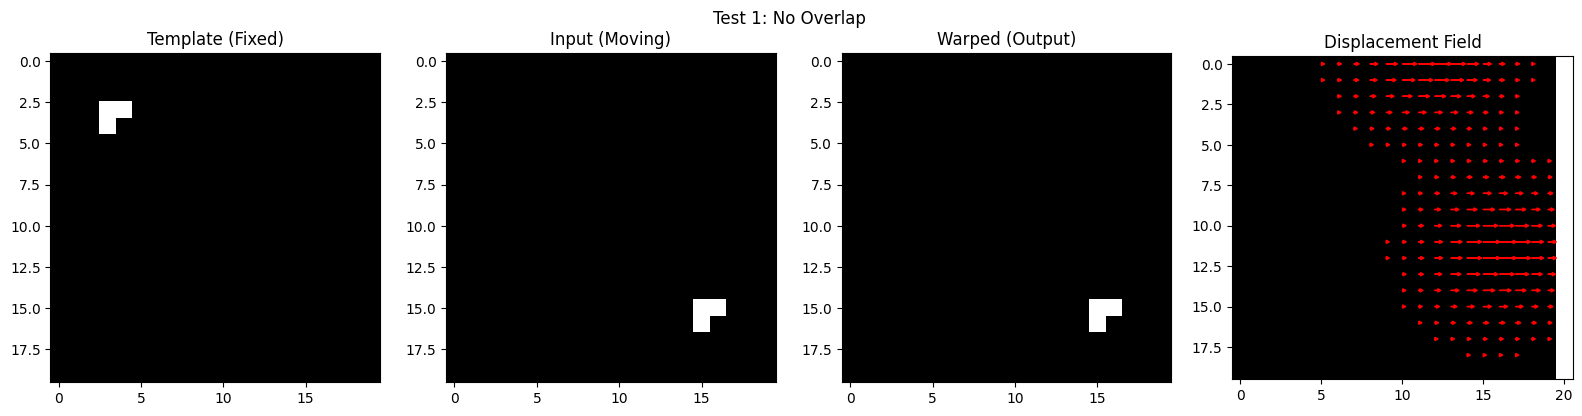

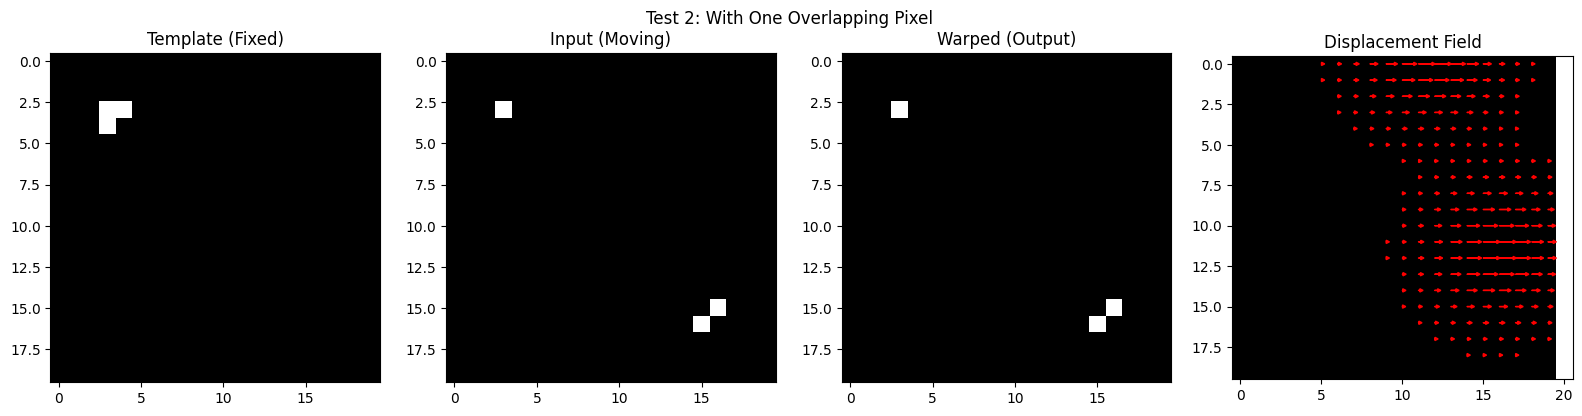

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

def create_binary_image(size, coords):
    """Create binary image with ones at specified coordinates"""
    img = np.zeros(size, dtype=np.float32)
    for y, x in coords:
        img[y, x] = 1.0
    return sitk.GetImageFromArray(img)

def run_registration(fixed_img, moving_img, control_point_spacing, control_point_deltas):
    transform = sitk.BSplineTransformInitializer(fixed_img, control_point_spacing, order=3)
    params = list(transform.GetParameters())
    num_points = len(params) // 2

    # اعمال جابجایی به کنترل‌پوینت‌ها
    for k, v in control_point_deltas.items():
        if k < len(params):
            params[k] += v
    transform.SetParameters(params)

    # تولید فیلد جابجایی
    disp_field = sitk.TransformToDisplacementField(transform,
        sitk.sitkVectorFloat64,
        fixed_img.GetSize(),
        fixed_img.GetOrigin(),
        fixed_img.GetSpacing(),
        fixed_img.GetDirection())
    deform_np = sitk.GetArrayFromImage(disp_field)

    # تصویر وارپ‌شده
    warped = sitk.Resample(moving_img, fixed_img, transform, sitk.sitkNearestNeighbor, 0.0)
    warped_np = sitk.GetArrayFromImage(warped)

    return warped_np, deform_np

def plot_results(fixed_np, moving_np, warped_np, deform_np, title):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(fixed_np, cmap='gray')
    axes[0].set_title("Template (Fixed)")
    axes[1].imshow(moving_np, cmap='gray')
    axes[1].set_title("Input (Moving)")
    axes[2].imshow(warped_np, cmap='gray')
    axes[2].set_title("Warped (Output)")
    axes[3].imshow(np.zeros_like(warped_np), cmap='gray')
    axes[3].set_title("Displacement Field")

    for y in range(fixed_np.shape[0]):
        for x in range(fixed_np.shape[1]):
            dx, dy = deform_np[y, x]
            if np.hypot(dx, dy) > 0.01:
                axes[3].arrow(x, y, dx, -dy, head_width=0.2, head_length=0.2, fc='red', ec='red')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# تنظیمات پایه
size = (20, 20)
spacing = [5, 5]

# تست 1: بدون اورلپ
template_coords_1 = [(3, 3), (3, 4), (4, 3)]
moving_coords_1 = [(15, 15), (15, 16), (16, 15)]

template_1 = create_binary_image(size, template_coords_1)
moving_1 = create_binary_image(size, moving_coords_1)
template_np_1 = sitk.GetArrayFromImage(template_1)
moving_np_1 = sitk.GetArrayFromImage(moving_1)

deltas = {12: 2.0, 12 + 25: 2.0}  # یک حرکت شدید برای مشاهده تغییر

warped_1, deform_1 = run_registration(template_1, moving_1, spacing, deltas)
plot_results(template_np_1, moving_np_1, warped_1, deform_1, "Test 1: No Overlap")


# تست 2: با یک پیکسل مشترک
template_coords_2 = [(3, 3), (3, 4), (4, 3)]
moving_coords_2 = [(3, 3), (15, 16), (16, 15)]  # یک نقطه مشترک با template

template_2 = create_binary_image(size, template_coords_2)
moving_2 = create_binary_image(size, moving_coords_2)
template_np_2 = sitk.GetArrayFromImage(template_2)
moving_np_2 = sitk.GetArrayFromImage(moving_2)

warped_2, deform_2 = run_registration(template_2, moving_2, spacing, deltas)
plot_results(template_np_2, moving_np_2, warped_2, deform_2, "Test 2: With One Overlapping Pixel")


In [ ]:
# -----------------------------------------------
# Register Frame 15 to All 30 Templates
# -----------------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimpleITK as sitk
from scipy.ndimage import center_of_mass
from IPython.display import display
from PIL import Image as PILImage

# ------------------ Paths ------------------
input_path = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/data/20213_2_0_masked.npy"
template_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/templates/Template10allsimNonrigid"
template_prefix = "template_phase"
template_suffix = "_similarity_10.npy"
save_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/notebooks/analysis_output/test"
os.makedirs(save_dir, exist_ok=True)

# ------------------ Load Test Frame ------------------
full_data = np.load(input_path)
frame_index = 15
test_frame = (np.abs(full_data[frame_index]) > 1e-6).astype(np.uint8)

# ------------------ Utility Functions ------------------
def compute_stats(mask):
    area = int(np.sum(mask))
    com_y, com_x = center_of_mass(mask) if area > 0 else (np.nan, np.nan)
    return area, com_y, com_x

def register_to_template(moving_mask, template):
    fixed = sitk.GetImageFromArray(template.astype(np.float32))
    moving = sitk.GetImageFromArray(moving_mask.astype(np.float32))

    # Rigid pre-alignment + BSpline
    initial_tx = sitk.CenteredTransformInitializer(
        fixed, moving, sitk.Euler2DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )
    bspline_tx = sitk.BSplineTransformInitializer(fixed, [10, 10])
    composite_tx = sitk.CompositeTransform(2)
    composite_tx.AddTransform(initial_tx)
    composite_tx.AddTransform(bspline_tx)

    registration = sitk.ImageRegistrationMethod()
    registration.SetMetricAsMattesMutualInformation(32)
    registration.SetOptimizerAsLBFGSB()
    registration.SetInitialTransform(composite_tx, inPlace=False)
    registration.SetInterpolator(sitk.sitkLinear)

    final_tx = registration.Execute(fixed, moving)
    aligned = sitk.Resample(moving, fixed, final_tx, sitk.sitkNearestNeighbor, 0.0)
    return sitk.GetArrayFromImage(aligned).astype(np.uint8)



# ------------------ Loop Over All Templates ------------------
rows = []
aligned_masks = []

for i in range(30):
    path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
    if not os.path.exists(path):
        print("Missing template:", path)
        continue

    template = np.load(path)
    template = (template > 0.5).astype(np.uint8)

    aligned = register_to_template(test_frame, template)

    a_tpl, y_tpl, x_tpl = compute_stats(template)
    a_in, y_in, x_in = compute_stats(test_frame)
    a_out, y_out, x_out = compute_stats(aligned)

    rows.append({
        'Frame': i,
        'Area_template': a_tpl,
        'COM_template_y': y_tpl,
        'COM_template_x': x_tpl,
        'Area_input': a_in,
        'COM_input_y': y_in,
        'COM_input_x': x_in,
        'Area_aligned': a_out,
        'COM_aligned_y': y_out,
        'COM_aligned_x': x_out,
        'Delta_A_after': a_out - a_tpl,
        'Delta_COM_y_after': y_out - y_tpl,
        'Delta_COM_x_after': x_out - x_tpl,
        'Delta_A_input_aligned': a_out - a_in,
        'Delta_COM_y_input_aligned': y_out - y_in,
        'Delta_COM_x_input_aligned': x_out - x_in,
    })

    aligned_masks.append(aligned)

# ------------------ Save Table ------------------
df = pd.DataFrame(rows)
csv_path = os.path.join(save_dir, "frame15_to_all_templates.csv")
df.to_csv(csv_path, index=False)
print("Saved table to:", csv_path)

# ------------------ Save/Show Image Grid ------------------
aligned_masks = np.array(aligned_masks)
fig, axes = plt.subplots(30, 3, figsize=(12, 60))

for i in range(30):
    axes[i, 0].imshow(test_frame, cmap='gray')
    axes[i, 0].set_title(f"Input Frame {frame_index}", fontsize=8)
    axes[i, 0].axis('off')

    path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
    tpl = np.load(path)
    tpl = (tpl > 0.5).astype(np.uint8)
    axes[i, 1].imshow(tpl, cmap='gray')
    axes[i, 1].set_title(f"Template {i}", fontsize=8)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(aligned_masks[i], cmap='gray')
    axes[i, 2].set_title(f"Aligned {i}", fontsize=8)
    axes[i, 2].axis('off')

plt.tight_layout()
img_path = os.path.join(save_dir, "frame15_aligned_to_all_templates.png")
plt.savefig(img_path, dpi=300)
plt.close()
print("Saved visualization:", img_path)

# ------------------ Show Results ------------------
display(df.round(2))

img = PILImage.open(img_path)
plt.figure(figsize=(12, 80))
plt.imshow(img)
plt.axis('off')
plt.title("Frame 15: Input vs. Template vs. Aligned (to 30 Templates)", fontsize=14)
plt.show()


In [ ]:
# --------------------------------------------------
# Registration Evaluation Script - Rigid, BSpline, Composite
# --------------------------------------------------
# Purpose:
# This script was written to investigate a key issue observed in a previous registration workflow:
# despite executing the registration pipeline, the final transforms remained identity (i.e., no deformation/alignment occurred).
#
# Issue in Previous Version:
# - BSplineTransformInitializer was used without providing non-zero initial control point displacements.
# - A CompositeTransform combining Rigid and BSpline was created, but the BSpline part was not updated by the optimizer,
#   because its parameters started at zero and the optimizer didn't modify them.
# - As a result, the transform parameters stayed at zero, and the output mask was effectively identical to the input.
#
# What This Script Does:
# ✅ Explicitly tests registration with three modes: "rigid", "bspline", and "composite".
# ✅ Logs the number of non-zero transform parameters to check whether real alignment is occurring.
# ✅ Compares area and center of mass (COM) between the input mask, template, and aligned output.
# ✅ Saves these measurements for all 30 templates into a CSV file for further statistical analysis.
#
# Modifications and Improvements:
# - Ensured correct setup of BSplineTransformInitializer.
# - Tracked transform updates with detailed print logs per frame/mode.
# - Resampled outputs with sitkNearestNeighbor to preserve binary masks.
# - Measured registration effect using ΔArea and ΔCOM.
# - CSV output enables quantitative comparison across all modes and templates.
# --------------------------------------------------
# Registration Test Notebook (Rigid, BSpline, Composite)
# --------------------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimpleITK as sitk
from scipy.ndimage import center_of_mass

# ------------------ Paths ------------------
input_path = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/data/20213_2_0_masked.npy"
template_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/templates/Template10allsimNonrigid"
template_prefix = "template_phase"
template_suffix = "_similarity_10.npy"
save_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/notebooks/analysis_output/test_modes"
os.makedirs(save_dir, exist_ok=True)

# ------------------ Load Test Frame ------------------
full_data = np.load(input_path)
frame_index = 15
test_frame = (np.abs(full_data[frame_index]) > 1e-6).astype(np.uint8)

# ------------------ Utility Functions ------------------
def compute_stats(mask):
    area = int(np.sum(mask))
    com_y, com_x = center_of_mass(mask) if area > 0 else (np.nan, np.nan)
    return area, com_y, com_x

def register_to_template_testmode(
    moving_mask,
    template,
    mode="composite",
    bspline_grid_spacing=(10, 10),
    interpolator=sitk.sitkNearestNeighbor,
    metric='mattes',
    n_iterations=100,
    frame_idx=None
):
    fixed = sitk.GetImageFromArray(template.astype(np.float32))
    moving = sitk.GetImageFromArray(moving_mask.astype(np.float32))

    registration = sitk.ImageRegistrationMethod()

    if metric.lower() == 'mattes':
        registration.SetMetricAsMattesMutualInformation(32)
    elif metric.lower() == 'meansquares':
        registration.SetMetricAsMeanSquares()
    elif metric.lower() == 'correlation':
        registration.SetMetricAsCorrelation()
    else:
        raise ValueError("Unsupported metric")

    registration.SetOptimizerAsLBFGSB(
        gradientConvergenceTolerance=1e-5,
        numberOfIterations=n_iterations,
        maximumNumberOfCorrections=5,
        maximumNumberOfFunctionEvaluations=1000
    )

    registration.SetInterpolator(interpolator)

    if mode == "rigid":
        tx = sitk.CenteredTransformInitializer(
            fixed, moving, sitk.Euler2DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        registration.SetInitialTransform(tx, inPlace=False)
        final_tx = registration.Execute(fixed, moving)

    elif mode == "bspline":
        bspline_tx = sitk.BSplineTransformInitializer(
            image1=fixed,
            transformDomainMeshSize=bspline_grid_spacing,
            order=3
        )
        registration.SetInitialTransform(bspline_tx, inPlace=False)
        final_tx = registration.Execute(fixed, moving)

    elif mode == "composite":
        rigid_tx = sitk.CenteredTransformInitializer(
            fixed, moving, sitk.Euler2DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        bspline_tx = sitk.BSplineTransformInitializer(
            image1=fixed,
            transformDomainMeshSize=bspline_grid_spacing,
            order=3
        )
        composite_tx = sitk.CompositeTransform(2)
        composite_tx.AddTransform(rigid_tx)
        composite_tx.AddTransform(bspline_tx)
        registration.SetInitialTransform(composite_tx, inPlace=False)
        final_tx = registration.Execute(fixed, moving)

    else:
        raise ValueError("mode must be 'rigid', 'bspline', or 'composite'")

    params = np.array(final_tx.GetParameters())
    changed = not np.allclose(params, 0)
    print(f"[Frame {frame_idx}] Mode: {mode.upper()} | Non-zero Params: {np.sum(np.abs(params) > 1e-6)}")
    if not changed:
        print(f"[Frame {frame_idx}] ⚠️ Final transform is identity (no change)")
    else:
        print(f"[Frame {frame_idx}] ✅ Transform updated!")

    resampled_img = sitk.Resample(moving, fixed, final_tx, interpolator, 0.0)
    resampled_array = sitk.GetArrayFromImage(resampled_img)
    binary_mask = (resampled_array > 0.5).astype(np.uint8)

    return binary_mask

# ------------------ Run for all templates with 3 modes ------------------
results = []

for mode in ["rigid", "bspline", "composite"]:
    print("\n============================")
    print(f"Running mode: {mode.upper()}")
    print("============================")
    for i in range(30):
        path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
        if not os.path.exists(path):
            print("Missing template:", path)
            continue

        template = np.load(path)
        template = (template > 0.5).astype(np.uint8)

        aligned = register_to_template_testmode(
            test_frame, template,
            mode=mode,
            bspline_grid_spacing=(10, 10),
            interpolator=sitk.sitkNearestNeighbor,
            metric='mattes',
            n_iterations=100,
            frame_idx=i
        )

        a_tpl, y_tpl, x_tpl = compute_stats(template)
        a_in, y_in, x_in = compute_stats(test_frame)
        a_out, y_out, x_out = compute_stats(aligned)

        results.append({
            'Mode': mode,
            'Frame': i,
            'Area_template': a_tpl,
            'COM_template_y': y_tpl,
            'COM_template_x': x_tpl,
            'Area_input': a_in,
            'COM_input_y': y_in,
            'COM_input_x': x_in,
            'Area_aligned': a_out,
            'COM_aligned_y': y_out,
            'COM_aligned_x': x_out,
            'Delta_A_input_aligned': a_out - a_in,
            'Delta_COM_y_input_aligned': y_out - y_in,
            'Delta_COM_x_input_aligned': x_out - x_in,
        })

# ------------------ Save Results ------------------
df = pd.DataFrame(results)
output_path = os.path.join(save_dir, "frame15_all_modes.csv")
df.to_csv(output_path, index=False)
print("Saved CSV to:", output_path)

df.groupby("Mode")["Delta_A_input_aligned"].describe()


In [ ]:
# --------------------------------------------------
# Final Sanity Test for Registration - Manual Shift + Rigid Alignment
# --------------------------------------------------
# Purpose:
# This script performs a minimal and focused test to verify whether the registration pipeline 
# is functioning correctly when a known artificial transformation is applied.
#
# Motivation:
# In earlier tests, the final transforms across all registration modes (Rigid, BSpline, Composite)
# remained identity, suggesting that no actual alignment was being performed.
# This raised concerns that:
#   - The optimizer is not updating transforms
#   - The input and template might be too similar
#   - The metric or transform configuration might be ineffective
#
# What This Test Does:
# ✅ Takes a known binary mask (frame 15) and applies a manual shift to it using a translation transform.
# ✅ Uses the original (unshifted) version of that same frame as the template.
# ✅ Runs **only Rigid** registration to check if the transform correctly aligns the shifted mask back to its original position.
#
# Expected Result:
# - If registration works correctly, the output should closely resemble the original unshifted mask.
# - The final transform should **not** be identity, and the parameters should reflect the inverse of the manual shift.
#
# This test serves as a minimal, controlled scenario to confirm that:
# 1. The registration pipeline is correctly wired up
# 2. The optimizer and metric are functioning
# 3. Transform parameters are being updated

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Load Original ----------------
input_path = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/data/20213_2_0_masked.npy"
full_data = np.load(input_path)
frame_index = 15
original_mask = (np.abs(full_data[frame_index]) > 1e-6).astype(np.uint8)

# ---------------- Apply Manual Transform ----------------
def apply_manual_transform(mask, translation=(30, -15), rotation_degrees=10):
    image = sitk.GetImageFromArray(mask.astype(np.float32))
    tx = sitk.Euler2DTransform()
    tx.SetCenter(np.array(image.GetSize())[::-1] / 2.0)  # center = (x, y)
    tx.SetTranslation(translation)
    tx.SetAngle(np.deg2rad(rotation_degrees))
    resampled = sitk.Resample(image, image, tx, sitk.sitkNearestNeighbor, 0.0)
    return sitk.GetArrayFromImage(resampled).astype(np.uint8)

moved_mask = apply_manual_transform(original_mask)

# ---------------- Rigid Registration ----------------
def register_rigid(moving_mask, fixed_mask):
    fixed = sitk.GetImageFromArray(fixed_mask.astype(np.float32))
    moving = sitk.GetImageFromArray(moving_mask.astype(np.float32))

    initial_tx = sitk.CenteredTransformInitializer(
        fixed, moving, sitk.Euler2DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )

    registration = sitk.ImageRegistrationMethod()
    registration.SetMetricAsMeanSquares()
    registration.SetOptimizerAsRegularStepGradientDescent(
        learningRate=1.0,
        minStep=1e-6,
        numberOfIterations=200,
        relaxationFactor=0.5,
    )
    registration.SetInitialTransform(initial_tx, inPlace=False)
    registration.SetInterpolator(sitk.sitkNearestNeighbor)

    final_tx = registration.Execute(fixed, moving)
    print("Final Transform Parameters:", final_tx.GetParameters())
    aligned = sitk.Resample(moving, fixed, final_tx, sitk.sitkNearestNeighbor, 0.0)
    return sitk.GetArrayFromImage(aligned).astype(np.uint8)

recovered_mask = register_rigid(moved_mask, original_mask)

# ---------------- Visual Comparison ----------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original_mask, cmap='gray')
axes[0].set_title("Original")

axes[1].imshow(moved_mask, cmap='gray')
axes[1].set_title("Moved (Manual Transform)")

axes[2].imshow(recovered_mask, cmap='gray')
axes[2].set_title("Recovered (After Rigid)")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# --------------------------------------------------
# Visual Overlap Check: Frame 15 vs All Templates
# --------------------------------------------------
# Purpose:
# This script visualizes the overlap between the input mask (frame 15)
# and each of the 30 template masks used for registration.
#
# Motivation:
# In previous registration runs, all resulting transforms were identity,
# suggesting that the optimizer could not find any improvement.
#
# Hypothesis:
# The input and template masks may not have sufficient spatial overlap,
# making the similarity metric (e.g., MeanSquares, Mattes) ineffective.
#
# What This Script Does:
# ✅ Loads frame 15 from the input .npy file and binarizes it.
# ✅ Loads each of the 30 template masks.
# ✅ Overlays each template (green) on top of the input frame (red).
# ✅ Displays all overlays in a grid (6x5) for visual inspection.
#
# Expected Outcome:
# - Clear visual confirmation whether frame 15 has meaningful spatial
#   overlap with any of the templates.
# - Helps diagnose why registration might not be working in practice.

import os
import numpy as np
import matplotlib.pyplot as plt

# -------------------- مسیرها --------------------
input_path = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/data/20213_2_0_masked.npy"
template_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/templates/Template1simNonrigid"#Template10allsimNonrigid Template1simNonrigid
template_prefix = "template_phase"
template_suffix = "_similarity_10.npy"

# -------------------- بارگذاری فریم ۱۵ --------------------
full_data = np.load(input_path)
frame_15 = (np.abs(full_data[15]) > 1e-6).astype(np.uint8)

# -------------------- نمایش فریم ورودی روی تمام تمپلیت‌ها --------------------
fig, axes = plt.subplots(6, 5, figsize=(15, 18))
axes = axes.ravel()

for i in range(30):
    path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
    if not os.path.exists(path):
        print(f"Template {i} not found:", path)
        continue

    template = np.load(path)
    template = (template > 0.5).astype(np.uint8)

    overlay = np.zeros((frame_15.shape[0], frame_15.shape[1], 3), dtype=np.uint8)
    overlay[..., 0] = frame_15 * 255         # Red channel: input
    overlay[..., 1] = template * 255         # Green channel: template

    axes[i].imshow(overlay)
    axes[i].set_title(f"Template {i}", fontsize=10)
    axes[i].axis("off")

plt.tight_layout()
plt.suptitle("Frame 15 (Red) vs Templates (Green)", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------
# This script loads frame 15 from a given .npy file and overlays it (in red)
# on either:
#   1. A series of 30 individual template similarity .npy files, or
#   2. A single final template similarity .npy file named 'final_template_similarity_1.npy'
# The overlays are shown in a 6x5 grid (for 30 templates), or a single plot if only one exists.
# -----------------------------------------------

input_path = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/data/20213_2_0_masked.npy"
template_dir = r"P:/Projects/DeepFlow/deepFlowDocker/scripts/Registration/templates/Template1simNonrigid"  # Change as needed
template_prefix = "template_phase"
template_suffix = "_similarity_10.npy"
final_template_name = "final_template_similarity_1.npy"

# -------- Load frame 15 from the input numpy file --------
full_data = np.load(input_path)
frame_15 = (np.abs(full_data[15]) > 1e-6).astype(np.uint8)

# -------- Determine if we're using multiple templates or a single final template --------
final_template_path = os.path.join(template_dir, final_template_name)
use_single_template = os.path.exists(final_template_path)

if use_single_template:
    # -------- Load the final single template --------
    template = np.load(final_template_path)
    template = (template > 0.5).astype(np.uint8)

    overlay = np.zeros((frame_15.shape[0], frame_15.shape[1], 3), dtype=np.uint8)
    overlay[..., 0] = frame_15 * 255   # Red channel: input
    overlay[..., 1] = template * 255   # Green channel: template

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title("Frame 15 (Red) vs Final Template (Green)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

else:
    # -------- Load and display 30 separate templates --------
    fig, axes = plt.subplots(6, 5, figsize=(15, 18))
    axes = axes.ravel()

    for i in range(30):
        path = os.path.join(template_dir, f"{template_prefix}_{i:02d}{template_suffix}")
        if not os.path.exists(path):
            print(f"Template {i} not found:", path)
            continue

        template = np.load(path)
        template = (template > 0.5).astype(np.uint8)

        overlay = np.zeros((frame_15.shape[0], frame_15.shape[1], 3), dtype=np.uint8)
        overlay[..., 0] = frame_15 * 255   # Red channel: input
        overlay[..., 1] = template * 255   # Green channel: template

        axes[i].imshow(overlay)
        axes[i].set_title(f"Template {i}", fontsize=10)
        axes[i].axis("off")

    plt.tight_layout()
    plt.suptitle("Frame 15 (Red) vs Templates (Green)", fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()
